In [1]:
!pip install basedosdados

     |████████████████████████████████| 9.9 MB 26.8 MB/s 
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 187 kB 70.9 MB/s 
     |████████████████████████████████| 125 kB 78.0 MB/s 
     |████████████████████████████████| 101 kB 8.8 MB/s 
     |████████████████████████████████| 70 kB 7.1 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 546 kB 86.9 MB/s 
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully unin

In [2]:
!pip install pandas==1.1.5
!pip install geopandas

     |████████████████████████████████| 9.5 MB 11.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basedosdados 1.5.6 requires pandas==1.2.4, but you have pandas 1.1.5 which is incompatible.


     |████████████████████████████████| 994 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


In [3]:
!pip install -U mapclassify

In [4]:
#importando bibliotecas
import basedosdados as bd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
sns.set()

### **Mapa PIB per capita por municípios 2018**
(polígonos)



In [11]:
#query PIB per capita
query = """
SELECT 
    pib.id_municipio ,
    pop.ano, 
    pib.PIB / pop.populacao as pib_pc
FROM `basedosdados.br_ibge_pib.municipio` as pib
INNER JOIN `basedosdados.br_ibge_populacao.municipio` as pop
ON pib.id_municipio = pop.id_municipio AND pib.ano = pop.ano
"""

In [28]:
pib = bd.read_sql(query, billing_project_id='basedosdados-input')

Downloading: 100%|██████████| 94616/94616 [00:03<00:00, 30058.07rows/s]


In [13]:
#os dados reportam o PIB desde 2002, mas criamos o mapa somente com o ano de 2018
pib_2018 = pib[pib.ano.isin([2018])]

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
#shapefile com as coordenadas municipais
geometria = gpd.read_file('/content/drive/MyDrive/Brazil_ShapeFiles/brazil_munic/BRMUE250GC_SIR.shp')

In [23]:
#merge entre PIB e localização
mapa = pd.merge(pib_2018, geometria, 
                  how='left', left_on=['id_municipio'],
                              right_on=['CD_GEOCMU'])

In [24]:
mapa.drop(['ano', 'NM_MUNICIP', 'CD_GEOCMU'], axis=1, inplace=True)

In [25]:
#formatação do dataframe para o padrão geo
mapa = GeoDataFrame(mapa)

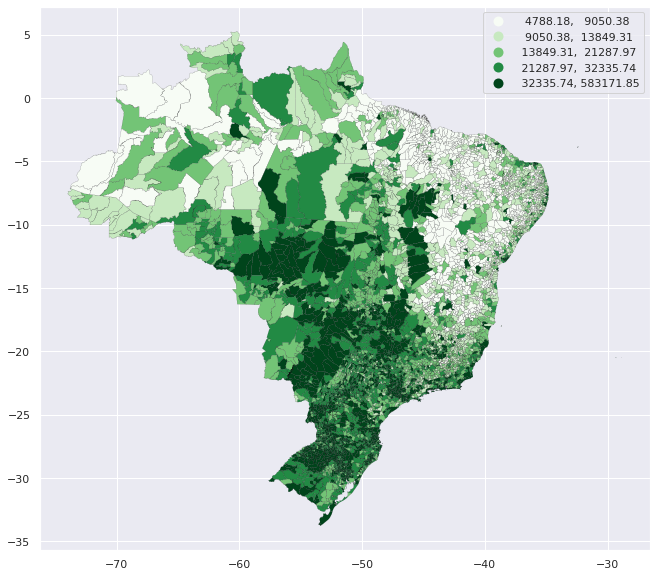

In [27]:
#criação do mapa, onde o scheme é criado pela biblioteca mapclassify
fig, ax = plt.subplots(1, 1, figsize=(15,10))
mapa.plot(column='pib_pc', ax=ax, legend=True, cmap='Greens', edgecolor='black', linewidth=0.1, scheme='Quantiles')
fig.savefig('pib_pc_2.png', transparent=True, dpi=fig.dpi)

### **Componentes do PIB (Brasil, 2002-2018)**

In [30]:
#a base contém informações do PIB municipal (com os valores adicionados) para o período de 2002 a 2018
pib_comp = bd.read_sql('SELECT * FROM `basedosdados.br_ibge_pib.municipio`', billing_project_id='basedosdados-input')
pib_comp.describe()

Downloading: 100%|██████████| 94616/94616 [00:02<00:00, 32230.87rows/s]


,ano,pib,impostos_liquidos,va,va_agropecuaria,va_industria,va_servicos,va_adespss
count,94616.000000,9.461600e+04,9.461600e+04,9.461600e+04,9.461600e+04,9.461600e+04,9.461600e+04,9.461600e+04
mean,2010.003002,7.287343e+08,1.052315e+08,6.235028e+08,3.313567e+07,1.531836e+08,3.329723e+08,1.042113e+08
std,4.898931,8.059832e+09,1.489081e+09,6.596790e+09,6.356696e+07,1.094854e+09,4.885391e+09,1.058767e+09
min,2002.000000,-1.904643e+07,-1.508840e+07,-5.105931e+08,-2.298910e+06,-2.897193e+09,3.722780e+05,1.446664e+06
25%,2006.000000,3.905784e+07,1.478442e+06,3.729948e+07,6.121093e+06,1.904200e+06,8.765398e+06,1.286555e+07
50%,2010.000000,8.971593e+07,4.477020e+06,8.467848e+07,1.519649e+07,6.322138e+06,2.362657e+07,2.568912e+07
75%,2014.000000,2.555032e+08,1.811785e+07,2.356625e+08,3.532677e+07,3.520165e+07,8.064128e+07,5.908990e+07
max,2018.000000,7.146834e+11,1.271543e+11,5.875291e+11,2.482540e+09,6.689305e+10,4.854288e+11,1.017928e+11


In [32]:
#agrupa por ano os valores adicionados 
pib_comp['pib_ano'] = pib_comp.groupby(['ano'])['pib'].transform(np.sum)
pib_comp['va_agro'] = pib_comp.groupby(['ano'])['va_agropecuaria'].transform(np.sum)
pib_comp['va_ind'] = pib_comp.groupby(['ano'])['va_industria'].transform(np.sum)
pib_comp['va_serv'] = pib_comp.groupby(['ano'])['va_servicos'].transform(np.sum)
pib_comp['va_ade'] = pib_comp.groupby(['ano'])['va_adespss'].transform(np.sum)

In [33]:
#mantém somente uma observação por ano, excluindo demais variáveis que foram agrupadas
pib_comp.drop_duplicates(subset=['ano'], keep ='first', inplace = True)
pib_comp.drop(['id_municipio', 'pib', 'impostos_liquidos', 'va', 'va_agropecuaria', 'va_industria', 'va_servicos', 'va_adespss'], axis=1, inplace=True)

In [36]:
#visualização do df
pib_comp

,ano,pib_ano,va_agro,va_ind,va_serv,va_ade
0,2002,1488787276039,81515198966,334907570007,644403214045,209388684020
5560,2003,1717950386056,105949164973,396568543017,732543684039,235655841993
11120,2004,1957751224028,110912703012,475863218000,815527583034,259678618984
16680,2005,2170584502984,100957547036,524686244007,922044704993,295129905954
22244,2006,2409449916019,105294010981,567281406012,1043094774978,333619786031
27808,2007,2720262950930,120151714997,629071170992,1193195220987,377110173985
33372,2008,3109803096975,142051181983,717907186036,1332296659026,434222689025
38936,2009,3333039338988,149212634996,729222075014,1484149305942,487178806006
44501,2010,3885846999973,159932000003,904158000021,1700905000023,537844999954
50066,2011,4376381999975,190023999999,1011034000004,1921343999999,598059000017


In [38]:
#reshape da base pra criação do gráfico de linhas
value_vars = ['pib_ano', 'va_agro', 'va_ind', 'va_serv', 'va_ade']
pib_comp = pd.melt(pib_comp, id_vars='ano', value_vars=value_vars, var_name='componente', value_name='valores')

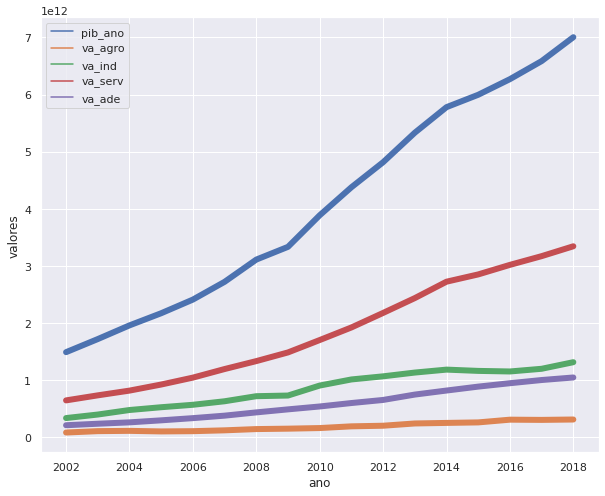

In [40]:
#criação do gráfico de linhas com resultado do PIB e seus componentes (em trilhões de R$)
plt.figure(figsize=(10,8))
graph_tec = sns.lineplot('ano', 'valores', hue='componente', data=pib_comp, linewidth=6.0)
graph_tec.legend(loc='upper left')
plt.savefig('pib_componentes.png', transparent=True, dpi=300)